# City Quality of Life 
### DOPP Group 9

In [166]:
import pandas as pd
import eurostat
import numpy as np
import os

pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None


## Response Variable Scraper: Quality of Life ranking from Numbeo

In [167]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

DEFAULT_YEAR=2020


class ReponseVariableScraper:

    def __init__(self):
        self.year=DEFAULT_YEAR
        self.url_base=f"https://www.numbeo.com/quality-of-life/rankings.jsp?title={self.year}&displayColumn=0"
        self.data={}
        self.european_countries=["Switzerland","Netherlands","Denmark",
"Austria","Luxembourg","Iceland","United Kingdom","Germany",
"Spain","Estonia","Sweden","Ireland","Slovenia","Lithuania",
        "Turkey","Czech Republic","Norway","Croatia",
        "France","Belgium","Portugal","Cyprus","Romania","Poland","Slovakia",
        "Latvia","Russia","Italy","Bulgaria","Serbia","Greece",
"Hungary","Ukraine"]

    def scrape_year(self,year,path=None):
        if year<2012 or year>2020: return
        if not os.path.exists("../data"):
            os.mkdir("../data")
        if not path: path = f"../data/Quality_of_life_{year}"

        self.year = year
        self.url_base = f"https://www.numbeo.com/quality-of-life/rankings.jsp?title={year}&displayColumn=0"
        if year==2012 or year ==2013:self.url_base = f"https://www.numbeo.com/quality-of-life/rankings.jsp?title={year}-Q1&displayColumn=0"

        self.__process_content()
        self.__save_data(path)

    def get_year(self,year,path=None):
        if not path: path = f"../data/Quality_of_life_{year}"
        try:
            df=pd.read_csv(path,header=0)
        except(FileNotFoundError):
            self.scrape_year(year)
            df=self.get_year(year)
        return df

    def __process_content(self):
        page = requests.get(self.url_base)
        soup = BeautifulSoup(page.content, "html.parser")
        tb = soup.find(id="t2")
        header = tb.find_all_next("th")
        headings = []
        for head in header:
            headings.extend(head.div.contents)
        body = tb.find_next("tbody").find_all("tr")
        ranks = []
        city = []
        qol = []
        rank = 1
        for row in body:
            content = row.find_all("td")
            ranks.append(rank)
            city.extend(content[1])
            qol.extend(content[2])
            rank+=1
        tupls = list(zip(ranks, city, qol))
        df = pd.DataFrame(tupls, columns=headings)
        cities = df["City"].map(lambda x: x.split(", ")[0])
        countries = df["City"].map(lambda x: x.split(", ")[1])
        df["City"] = cities
        df["Country"] = countries
        self.data[self.year]=df

    def __save_data(self,path):
        self.data[self.year].to_csv(path,header=True)
    def __filter_europe(self,df):
        df=df[df["Country"].isin(self.european_countries)]
        return df

    def __fill_nan(self,df):
        cols = df.columns
        n = df.to_numpy().reshape((len(cols),))
        x = cols[np.argwhere(~np.isnan(n))]
        y = n[np.argwhere(~np.isnan(n))]
        reg = LinearRegression().fit(x, y)
        miss = cols[np.argwhere(np.isnan(n))]
        pred = reg.predict(miss)
        n[np.argwhere(np.isnan(n))] = pred
        return n
    def get_interpolated_years(self):
        data = {}
        for year in range(2012, 2021):
            data[year] = self.get_year(year)
            data[year] = self.__filter_europe(data[year])
            data[year]["Rank"] = range(1, len(data[year]) + 1)
        all_cities = []
        for year in range(2012, 2021):
            all_cities.extend(data[year]["City"].unique())
        all_cities=list(set(all_cities))
        complete_data = pd.DataFrame(
            columns=["City", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"])
        complete_data["City"] = all_cities
        for year in range(2012, 2021):
            data_year = data[year]
            for city in all_cities:
                c = data_year["City"].to_list()
                if city in c:
                    g = data_year[data_year["City"] == city]["Quality of Life Index"].to_list()[0]
                    indx = complete_data[complete_data["City"] == city]
                    indx[str(year)] = float(g)
                    complete_data[complete_data["City"] == city] = indx
                else:
                    complete_data[complete_data["City"] == city][year] = np.nan
        res = []
        for city in all_cities:
            g = complete_data[complete_data["City"] == city]
            d = g[["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]]
            data_year = d
            data_year = pd.DataFrame(data_year, dtype='float32')
            data_year.interpolate(method='linear', axis=0, inplace=True)
            if data_year.isnull().values.any():
                data_year = self.__fill_nan(data_year)
            else:
                data_year = data_year.to_numpy()
            fill = pd.DataFrame(columns=["City", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"])
            fill["City"] = [city]
            fill[["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]] = data_year
            v = fill.values
            res.append(v[0])
            complete_data[complete_data["City"] == city] = fill
        complete_data.head()
        g = pd.DataFrame(res, columns=["City", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"])
        return g



In [168]:

european_countries=["Switzerland","Netherlands","Denmark",
"Austria","Luxembourg","Iceland","United Kingdom","Germany",
"Spain","Estonia","Sweden","Ireland","Slovenia","Lithuania",
        "Turkey","Czech Republic","Norway","Croatia",
        "France","Belgium","Portugal","Cyprus","Romania","Poland","Slovakia",
        "Latvia","Russia","Italy","Bulgaria","Serbia","Greece",
"Hungary","Ukraine"]

def filter_europe(df):
    df=df[df["Country"].isin(european_countries)]
    return df


data_scraper = ReponseVariableScraper()

for year in range(2012,2021):
    data_scraper.scrape_year(year)

#### Ranking & Score Aggregation
After the necessary preprocessing has been done the next step in our time analysis is to summerize all the dataset into a dictionary containing the response variable, the ranking and city for every year.
Furthermore, two a dataframe was created which counts for every city how often it scored in the top 10 by ranking during the time period 2012-2020. Additionally, a dataframe which accumulates for every
city the scores that it received over the years. At last both dataframes were sorted by their counts of ranking or accumulated scores in descending order.



In [169]:
import numpy as np
data={}
for year in range(2012,2021):
    data[year]=data_scraper.get_year(year)
    data[year]=filter_europe(data[year])
    data[year]["Rank"]=range(1,len(data[year])+1)
all_cities=[]
for year in range(2012,2021):
    all_cities.extend(data[year]["City"].unique())

all_cities=np.unique(all_cities)
cities=pd.DataFrame(columns=["City","Top_10"])
cities["City"]=all_cities
cities["Top_10"]=0
QOL_acc=pd.DataFrame(columns=["City","QOL_acc"])
QOL_acc["City"]=all_cities
QOL_acc["QOL_acc"]=0
for year in range(2012,2021):
    df=data[year]
    df.sort_values(by="City",inplace=True)
    candidates=df[df["Rank"]<=10]["City"].to_list()
    idx_c=cities["City"].isin(candidates)
    cities["Top_10"].loc[idx_c]+=1
    c=df["City"].to_list()
    idx_acc=QOL_acc["City"].isin(c)
    q=df["Quality of Life Index"].to_list()
    QOL_acc["QOL_acc"][idx_acc]+=q
cities.sort_values(by=["Top_10"],ascending=False,inplace=True)
qol_response=data_scraper.get_interpolated_years()
#qol_response.head()

<ipython-input-167-eb3a4f6c32aa>:84: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = cols[np.argwhere(~np.isnan(n))]
<ipython-input-167-eb3a4f6c32aa>:87: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  miss = cols[np.argwhere(np.isnan(n))]
<ipython-input-167-eb3a4f6c32aa>:84: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = cols[np.argwhere(~np.isnan(n))]
<ipython-input-167-eb3a4f6c32aa>:87: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a

In [170]:
##reshape (melt) into city-year : value shape, convert year to int to match others\n",

response = qol_response.melt(id_vars=['City'], value_vars=['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012'],
                         var_name = 'Year', value_name='QOL')
response['Year'] = response['Year'].astype(int)

In the figure below the dataframe which depicts the number of times a city scored in the top 10 is visualized.

### Climate: Cooling and heating degree days by NUTS 2 regions

In [171]:
## get eurostat data
heatdays = eurostat.get_data_df('nrg_chddr2_a', flags=False)
heatdays = heatdays.iloc[:,:11].rename(columns={'geo\\time': ' NUTS 2'})

## Merge on all entries which are also in the target variable cities to extract only the interesting cities
target_cities = pd.read_csv("../data/Cities_with_codes.csv")
heatdays_nuts = pd.merge(target_cities, heatdays, on=[' NUTS 2'], how='left')

## split into cool & heating days
heatdays_cdd = heatdays_nuts.iloc[np.where(heatdays_nuts.indic_nrg == 'CDD')]
heatdays_hdd = heatdays_nuts.iloc[np.where(heatdays_nuts.indic_nrg == 'HDD')]

# impute missing heat days
missing_heat = heatdays_nuts.iloc[np.where(heatdays_nuts.indic_nrg.isna())]
missing_heat['indic_nrg'] = 'HDD'
for year in range(2012, 2020):
    missing_heat[year] = heatdays_hdd[year].mean(axis=0)
heatdays_hdd = heatdays_hdd.append(missing_heat)

## impute missing cool days
missing_cool = heatdays_nuts.iloc[np.where(heatdays_nuts.indic_nrg.isna())]
missing_cool['indic_nrg'] = 'CDD'
for year in range(2012, 2020):
    missing_cool[year] = heatdays_cdd[year].mean(axis=0)
heatdays_cdd = heatdays_cdd.append(missing_cool)

## reshape (melt) into city-year : value shape
heat = heatdays_hdd.melt(id_vars=['City'], value_vars=[2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012],\
                         var_name = 'Year', value_name='Heatdays')
cool = heatdays_cdd.melt(id_vars=['City'], value_vars=[2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012],\
                         var_name = 'Year', value_name='Cooldays')
heat.shape
#heatdays_cdd.to_csv('../data/heatdays_hdd.csv')
#heatdays_hdd.head()

(648, 3)

## Pollution

In [172]:
## scrape Pollution from Numbeo using modified version of Response Scraper
!python Pollution_Scraper.py

In [173]:

## for each year: read QOL + pollution csv, merge, add year, append to combined df 
pollution = pd.DataFrame()    
for year in range(2012,2020):
    ## read pollution for year
    filename = ('../data/' + 'Pollution_' + str(year))
    df_yr = pd.read_csv(filename).iloc[:,2:4]

    ## define year and rename
    df_yr.loc[:,'Year'] = int(year)
    df_yr = df_yr.rename(columns = {'Pollution Index':'Pollution','Quality of Life Index':'QOL'})
    
    ## concat to combined df
    pollution = pd.concat([pollution, df_yr])
    
## reshape & interpolate missing values
pollution_filled = pollution.pivot_table(index = 'City', columns = 'Year')
pollution_filled = pollution_filled.interpolate(method='linear', axis=1, limit_direction='both')

## merge back & fill missing city (Ankara)
pollution_merge = pd.merge(target_cities, pollution_filled, on=['City'], how='left').fillna(50)

## rename columens, merge back
renamed = pollution_merge.iloc[:,4:].rename(columns = lambda name: int(str(name).split()[1][0:4]))
city_id = pollution_merge.iloc[:,0:1]
pollution_named = pd.concat([renamed, city_id], axis=1)

## melt to right shape
pollution = pollution_named.melt(id_vars=['City'], value_vars=[2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012],\
                           var_name = 'Year', value_name='Pollution')

C:\Users\karle\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


### Education Attainment
From the eurostat dataset on education Population by educational attainment level (edat1) we use the sub-data set Population aged 25-64 by educational attainment level, sex and NUTS 2 regions (%) (edat_lfse_04). With educational attainment meaning the
highest level of completed education, the data is divided into the three sub categories ED 0-2 (less than primary - primary education), ED 3-4 (lower secondary - post secondary education) and ED 5-8 (tertiary education i.e. university studies). Each city
is given the values of the corresponding NUTS 2 region.

Every city from the target variables are found represented in the
data, however a few (['Belgrade', 'Budapest', 'Edinburgh', 'Kaunas', 'Vilnius', 'Warsaw']) have missing values for 2012.
Since this data is the earliest value it is not possible to interpolate. One option would be to use the later data points as a baseline
 for linear extrapolation, however because of the few datapoints and relatively high variance between the values this
 gave results with quite high variation, it is then more likely to guess a stronger trend than exists. Therefore we simply pad with the 2013 value since the
  value is most likely to be close to the coming year and also should be closer than using the mean of all the years.
Furthermore the data from Glasgow was almost completely missing except for 2012, but since Glasgow is a relatively large city in Scotland the population is close to 33% percent of the population
of the whole of Scotland (the NUTS 1 region) which is available we fill it with these values as an approximation.

Finally we separate the data into the three different brackets of educational level and drop the data for the total levels. This is since it should be
a significant difference especially between the primary/secondary and the tertiary education since in general the first to
are more heavliy regulated and handled on a governmental/regional compared to the Universities and similiar that usually are independent.


## !IMPORTANT!
Unfortunately there was an update of the data on the eurostat page on 2021-01-25 which
for some reason included more missing values but most of all multiple lines, as this was noticed on
2021-01-26 we do not have time to fix it. Also we did not have a saved copy of the data (lesson learned).
But fortunately there was a save .csv file with the output of the old data set and the code from below
we therefore attach it and read it in instead (but it was obtained using the commented code below)

In [174]:
# # Import the data from Eurostat
# df = eurostat.get_data_df('edat_lfse_04')
# df.columns = df.columns.astype(str)
#
# # Drop all years before 2012 and columns unit and age (same for all entries)
# df = df.drop(df.loc[:, '2011': '2000'].columns, axis = 1)
# df = df.drop(['unit', 'age'], axis = 1)
#
# # Keep only total values and discard the gender column
# df = df[df.sex == 'T']
# df = df.drop('sex', axis = 1)
#
# # Categories added on 2021-01-25, quick fix to get rid of them
# df = df[df.isced11 != 'ED3_4GEN']
# df = df[df.isced11 != 'ED3_4VOC']
#
# # Rename to avoid problems using \
# df = df.rename(columns={'geo\\time': ' NUTS 2'})
#
# # Merge on all entries which are also in the target variable cities to extract only the interesting cities
# #target_cities = pd.read_csv("../data/Cities_with_codes.csv")
# education_attainment = pd.merge(target_cities, df, on=[' NUTS 2'])
#
# # Glasgow is missing all values except 2012
# Glasgow = education_attainment.loc[education_attainment['City'] == 'Glasgow']
# # Whole region of Scotland is UKM
# # Glasgow (Metro area) is approx 33% of the population it should be a reasonable approximation
# temp  = df[df[' NUTS 2'] == 'UKM']
# temp = temp.loc[:,'2019':'2013']
# Glasgow.loc[:, '2019':'2013'] = temp.loc[:, '2019':'2013'].to_numpy()
# education_attainment[education_attainment['City'] == 'Glasgow'] = Glasgow
#
#
# # Impute the missing values from 2012 using padding
# education_attainment.loc[:, '2019':'2012'] = education_attainment.loc[:, '2019':'2012'].fillna(method='pad',axis=1)

# # Split in to 3 separate tables depending on education level
# edu_ED_0_2 = education_attainment[education_attainment['isced11'] == 'ED0-2']
# edu_ED_3_4 = education_attainment[education_attainment['isced11'] == 'ED3_4']
# edu_ED_5_8 = education_attainment[education_attainment['isced11'] == 'ED5-8']
#
# #To be able to merge with the other data
# #Transform the columns of each year to a variable year
# yearly_data = dict()
# education_attainment  = pd.DataFrame()
# for year in range(2012,2020):
#     yearly_data= edu_ED_0_2[ list(edu_ED_0_2.loc[:,'City':' Country']) + [f"{year}"]]
#     yearly_data.insert(4, "Year", year)
#     yearly_data = yearly_data.rename(columns={f"{year}": "Education Attainment ED 0-2"})
#     yearly_data.insert(6, "Education Attainment ED 3-4", edu_ED_3_4[f"{year}"].to_numpy())
#     yearly_data.insert(7, "Education Attainment ED 5-8", edu_ED_5_8[f"{year}"].to_numpy())
#     education_attainment = education_attainment.append(yearly_data)
#
# education_attainment = education_attainment.reset_index(drop=True)

education_attainment = pd.read_csv('../data/Education_Attainment.csv')

### Average Working Hours

From the eurostat data Regional labour market statistics (reg_lmk) we use the dataset Average number of usual weekly hours of work in main job by sex, age and NUTS 2 regions (lfst_r_lfe2ehour), which contains data
of working hours for a wide variety of different age categories and gender. We are however only interested in a total average
for both sexes and all ages so we only use the largest agespan (15-74).

The data is used as a measure of how much the average person
 needs to work every week which is clearly connected to the amount of leisure time which should have a large impact on the quality of life. The missing data is missing in the exact same spots as
in the educational attainment data so we use the same approach here.

In [175]:
# Load the datasheet from eurostat
df = eurostat.get_data_df('lfst_r_lfe2ehour')

# Drop all years before 2012 and columns unit and age (same for all entries)
df.columns = df.columns.astype(str)
df = df.drop(df.loc[:, '2011': ].columns, axis = 1)
# Rename to avoid problems using \
df = df.rename(columns={'geo\\time': ' NUTS 2'})

# Extract the data for both sexes (Total) and age group 15-74
df = df[df.sex == 'T']
df = df.drop('sex', axis = 1)
df = df[df.age == 'Y15-74']

# Merge on all entries which are also in the target variable cities to extract only the interesting cities
avg_hours = pd.merge(target_cities, df, on=[' NUTS 2'])

# Glasgow is missing all values except 2012
Glasgow = avg_hours.loc[avg_hours['City'] == 'Glasgow']
# Whole region of Scotland is UKM
# Glasgow is 40% of the population it should be a reasonable approximation
temp  = df[df[' NUTS 2'] == 'UKM']
temp = temp.loc[:,'2019':'2013']
Glasgow.loc[:, '2019':'2013'] = temp.loc[:, '2019':'2013'].to_numpy()
avg_hours[avg_hours['City'] == 'Glasgow'] = Glasgow

# Impute the rest using padding
#avg_hours = avg_hours.interpolate(method='pad',axis=1)
avg_hours.loc[:, '2019':'2012'] = avg_hours.loc[:, '2019':'2012'].fillna(method='pad',axis=1)

#To be able to merge with the other data
#Transform the columns of each year to a variable year
yearly_data = dict()
avg_working_hours  = pd.DataFrame()
for year in range(2012,2020):
    yearly_data= avg_hours[ list(avg_hours.loc[:,'City':' Country']) + [f"{year}"]]
    yearly_data.insert(4, "Year", year)
    yearly_data = yearly_data.rename(columns={f"{year}": "Average Working Hours"})
    avg_working_hours = avg_working_hours.append(yearly_data)
avg_working_hours = avg_working_hours.reset_index(drop=True)

### Unemployment Rate

From the eurostat data Regional labour market statistics (reg_lmk) we use the dataset 	Unemployment rates by sex, age and NUTS 2 regions (lfst_r_lfu3rt).
Once again we are only interested in total statistics for the genders and the largest age-group and therefore use only the entries with sex 'T' and agespan 15-74.
Also once again the same data is missing (likely these were all reported/obtained in the same survey).

In [176]:
# Read the datasheet from Eurostat
df = eurostat.get_data_df('lfst_r_lfu3rt')

# Drop all years before 2012 and columns unit and age (same for all entries)
df.columns = df.columns.astype(str)
df = df.drop(df.loc[:, '2011': ].columns, axis = 1)
# Rename to avoid problems using \
df = df.rename(columns={'geo\\time': ' NUTS 2'})

# Extract the data for both sexes (Total) and age group 15-74
df = df[df.sex == 'T']
df = df[df.age == 'Y15-74']
df = df.drop(['sex','unit','age'], axis = 1)

# Merge on all entries which are also in the target variable cities to extract only the interesting cities
unemployment_rate = pd.merge(target_cities, df, on=[' NUTS 2'])

# Glasgow is missing all values except 2012
Glasgow = unemployment_rate.loc[unemployment_rate['City'] == 'Glasgow']
# Whole region of Scotland is UKM
# Glasgow is 40% of the population it should be a reasonable approximation
temp  = df[df[' NUTS 2'] == 'UKM']
temp = temp.loc[:,'2019':'2013']
Glasgow.loc[:, '2019':'2013'] = temp.loc[:, '2019':'2013'].to_numpy()
unemployment_rate[unemployment_rate['City'] == 'Glasgow'] = Glasgow

# Impute the rest using padding
#unemployment_rate = unemployment_rate.interpolate(method='pad',axis=1)
unemployment_rate.loc[:, '2019':'2012'] = unemployment_rate.loc[:, '2019':'2012'].fillna(method='pad',axis=1)

#To be able to merge with the other data
#Transform the columns of each year to a variable year
yearly_data = dict()
unemployment_rate_data  = pd.DataFrame()
for year in range(2012,2020):
    yearly_data= unemployment_rate[ list(unemployment_rate.loc[:,'City':' Country']) + [f"{year}"]]
    yearly_data.insert(4, "Year", year)
    yearly_data = yearly_data.rename(columns={f"{year}": "Unemployment_Rate"})
    unemployment_rate_data = unemployment_rate_data.append(yearly_data)
unemployment_rate_data = unemployment_rate_data.reset_index(drop=True)

### Victims in Road Accidents

From the eurostat data Regional transport statistics (reg_tran) we use the dataset 	Victims in road accidents by NUTS 2 regions (tran_r_acc).
The dataset contains data on a NUTS 2 level for reported road accidents. There are different measures availible, but we use P_MHAB (Per million inhabitants)
as it gives a good way to compare the cities (with a wide variety of different sizes) to each other. There are also two different
variables of reported accident: accidents with injuries or accidents with lethal outcome. Even though the injury data might
be a better measure of the road safety in a city there is more data missing and hence we decided on the accidents with lethal outcome. Also the
accidents with injueries there might be a larger dependency on willingness to report crimes than in the lethal accidents
which are more likely very highly reported.

Here there is also more data missing, there is no data at all for the cities
Reykjavik, Edinburgh, Glasgow and Belgrade. Traffic data for these regions were obtained by searching up other data sources
such as governmental reports from the corresponding countries and then approximated to the city. Also there is no data
available at all for the year 2019 for which we pad the values from 2018.

In [177]:
# Get the data from Eurostat
df = eurostat.get_data_df('tran_r_acci')
df.columns = df.columns.astype(str)
# Drop all years before 2012, keep only with unit measure Per Million Inhabitants and accident type deadly
df = df.drop(df.loc[:, '2011': ].columns, axis = 1)
df = df[df.unit == 'P_MHAB']
df = df[df.victim == 'KIL']

# Rename to avoid problems using \
df = df.rename(columns={'geo\\time': ' NUTS 2'})

# Insert missing cloumn for 2019
df.insert(3,"2019",np.NaN)

# Merge on all entries which are also in the target variable cities to extract only the interesting cities
road_accidents = pd.merge(target_cities, df, on=[' NUTS 2'])

# Check for missing cities
missing_cities = target_cities[-target_cities[' NUTS 2'].isin(road_accidents[' NUTS 2'])]


print("Missing cities: ", missing_cities.values[:,0])

# Data from Icelandic ministry of transportation
#https://www.samgongustofa.is/umferd/tolfraedi/slysatolur/arsskyrslur-slysaskraningar/
# Reported as deaths per 10,000
Reykjavik  = [0.0, 30.0, 20.0, 10.0, 20.0, 0.0, 10.0, 10.0]
Reykjavik = ['Reykjavik', 'IS001C1','IS00','IS','KIL','P_MHAB']+Reykjavik
road_accidents.loc[77] = Reykjavik

# Table 1-1 in : https://www.abs.gov.rs/admin/upload/documents/20181016102533-statistical_report_2016_english.pdf
# 20% of the population is in Belgrade so we take 20% of the accidents as occuring there
# and divide by 1.7 (million inhabitants)
Belgrade = [np.NaN, np.NaN,np.NaN, 619, 594, 476, 548, 551]
Belgrade = np.multiply(Belgrade,(0.2/1.7))
Belgrade = np.around(Belgrade, 1)
Belgrade = ['Belgrade', '-','RS11','RS','KIL','P_MHAB']+Belgrade.tolist()
road_accidents.loc[78] = Belgrade

# Traffic death data from Scotland
# https://statistics.gov.scot/data/road-safety
# Select by region

# Divide by 0.5 (million inhabitants)
Edinburgh = [np.NaN, 5, 6, 9, 3, 11, 8, 13]
Edinburgh = np.divide(Edinburgh,0.5)
Edinburgh = np.around(Edinburgh, 1)
Edinburgh = ['Edinburgh', 'UK007C1','UKM7','UK','KIL','P_MHAB']+Edinburgh.tolist()
road_accidents.loc[79] = Edinburgh

# Divide by 0.6 (million inhabitants)
Glasgow = [np.NaN, 10, 7, 8, 15, 18, 4, 7]
Glasgow = np.divide(Glasgow,0.6)
Glasgow = np.around(Glasgow, 1)
Glasgow = ['Glasgow', 'UK004C1','UKM3','UK','KIL','P_MHAB']+Glasgow.tolist()
road_accidents.loc[80] = Glasgow

# Impute using padding to fill missing values
road_accidents.loc[:, '2019':'2013'] = road_accidents.loc[:, '2019':'2012'].fillna(method='backfill',axis=1)
road_accidents.loc[:, '2019':'2012'] = road_accidents.loc[:, '2019':'2012'].fillna(method='ffill',axis=1)

#To be able to merge with the other data
#Transform the columns of each year to a variable year
yearly_data = dict()
deaths_in_road_accidents  = pd.DataFrame()
for year in range(2012,2020):
    yearly_data= road_accidents[ list(road_accidents.loc[:,'City':' Country']) + [f"{year}"]]
    yearly_data.insert(4, "Year", year)
    yearly_data = yearly_data.rename(columns={f"{year}": "Deaths_in_road_accidents"})
    deaths_in_road_accidents = deaths_in_road_accidents.append(yearly_data)
deaths_in_road_accidents = deaths_in_road_accidents.reset_index(drop=True)


Missing cities:  ['Belgrade' 'Edinburgh' 'Glasgow' 'Reykjavik']


### Merge Education, Unemployemnt Rate, Accidents & Working Hours

In [178]:
data_sheets = [deaths_in_road_accidents,avg_working_hours,unemployment_rate_data]

initial = education_attainment
merged = initial

for file_name in data_sheets:
    temp_dataframe = file_name
    values = temp_dataframe.drop(columns=[' City Code', ' NUTS 2',' Country'])
    merged = merged.merge(values, on=['City', 'Year'])
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
    
print(merged.shape)
merged.head()

(648, 12)


,Unnamed: 0,City,City Code,NUTS 2,Country,Year,Education Attainment ED 0-2,Education Attainment ED 3-4,Education Attainment ED 5-8,Deaths_in_road_accidents,Average Working Hours,Unemployment_Rate
0,0,Amsterdam,NL002C1,NL32,NL,2012,23.4,38.0,38.5,33.0,30.6,5.4
1,1,Ankara,TR001C1,TR51,TR,2012,52.4,22.1,25.5,42.0,48.7,8.3
2,2,Antwerp,BE002C1,BE2,BE,2012,26.1,38.5,35.4,60.0,37.2,4.5
3,3,Athens,EL001C1,EL30,EL,2012,22.5,44.1,33.4,59.0,40.6,25.8
4,4,Barcelona,ES002C1,ES51,ES,2012,44.9,22.3,32.8,45.0,37.8,22.5


### Health and Gender

Unfortunately, parts of the health data could not be retrieved using the scrapper. We thus downloaded it to a .csv file manually from the website (https://ec.europa.eu/eurostat/databrowser/view/hlth_rs_prsrg/default/table?lang=en). On a NUTS2 level the health variables available are life expectancy and medical staff. The later is subdivided (There seems to be the problem with the scrapper.) into absolute and relative number as well as certain classes of personnel: Dentists, medical doctors, midwifes, etc. We chose the variable 'medical doctors' and decided to use the relative number per 100.000 inhabitants as the observed cities vary largely in population. Pre-processing has been necessary for missing values. First, linear interpolation has been used to calculate single missing values. Second, if consecutive values have been missing a simple regression has been applied to calculate the missing values. Third, if no data has been available for a given city at all, we had to resort to the next more crude granularity to use that data instead which had to be applied for example for Warsaw. Last, for all cities of the United Kingdom and Ireland data on medical personnel has neither been reported on a NUTS2 nor on a NUTS1 level. We thus had to use national data to fill in the gaps. As a result all English, Scottish and northern Irish have the same number of medical doctors per 100.000 inhabitants. The same goes for the Irish cities Cork and Dublin. 

Additionally the variable 'gender unemployment gap' has been chosen to approximate the level of equality. It is the difference between male and female unemployment rate and monitors female labor market access. It should be corrected for overall unemployment rate to take economic development into consideration. So this might not be the best variable to measure gender inequality, but it is the only one on a regional level we could find. The data has been available for all cities except for Belgrade which we approximated using the average of the neighboring capitals Budapest, Bucharest and Sofia for each year. 

In [179]:
health_gender = pd.read_csv('../data/Cities_Health_Gender.csv')
health_gender = health_gender.drop(columns=[' City Code', ' NUTS 2',' Country'])
#health_gender.head(1)

## Merge all datasets

In [180]:
join = 'inner'
#join = 'outer'

heatcool = pd.merge(heat, cool, how=join, on=['City','Year'] )
print(heatcool.shape)

heatcoolpol = pd.merge(heatcool, pollution, how=join, on=['City','Year'] )
print(heatcoolpol.shape)

tmppolres = pd.merge(heatcoolpol, response , how=join, on=['City','Year'] )
print(tmppolres.shape)
tmppolres.head(1)

(648, 4)
(648, 5)
(648, 6)


,City,Year,Heatdays,Cooldays,Pollution,QOL
0,Amsterdam,2019,2476.15,33.41,30.77,173.289993


In [181]:
halfdata = pd.merge(tmppolres, merged , how=join, on=['City','Year'] )
halfdata = halfdata.drop(columns=[' City Code', ' NUTS 2',' Country'])
print(halfdata.shape)
#halfdata.head(3)

(648, 13)


In [182]:
alldata = pd.merge(halfdata, health_gender, how=join, on=['City','Year'] )
print(alldata.shape)
alldata.head(3)

(648, 16)


,City,Year,Heatdays,Cooldays,Pollution,QOL,Unnamed: 0,Education Attainment ED 0-2,Education Attainment ED 3-4,Education Attainment ED 5-8,Deaths_in_road_accidents,Average Working Hours,Unemployment_Rate,E_Life_expextancy_at_birth,E_Med_Doctors_per_100000,Gender_Employment_Gap
0,Amsterdam,2019,2476.15,33.41,30.77,173.289993,567,17.9,33.7,48.5,32.0,30.8,3.2,82.2,487.53,7.9
1,Antwerp,2019,2372.84,37.23,60.27,157.899994,569,18.4,40.6,41.0,47.0,37.6,3.2,82.6,271.78,10.2
2,Athens,2019,1079.58,549.72,58.25,126.580002,570,15.0,44.9,40.2,48.0,40.2,16.9,81.7,792.04,17.8


### Save as csv

In [183]:
## inner shape: (376, 15), outer: (1072, 15) 
if join == 'inner':
    alldata.to_csv('../data/Full_data_inner.csv', index = False)
elif join == 'outer':
    alldata.to_csv('../data/Full_data_outer.csv', index = False)

In [184]:
all_inner = pd.read_csv('../data/Full_data_inner.csv')
all_inner.shape

(648, 16)

# Plotting Response

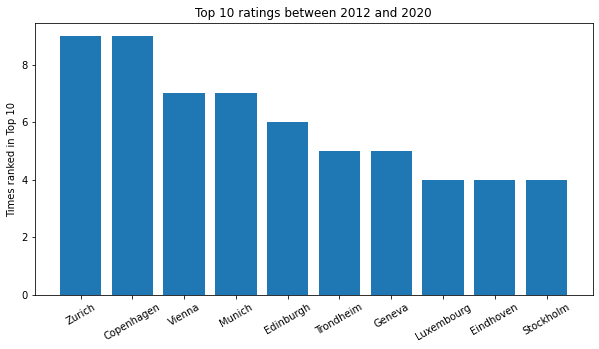

In [185]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(x=cities.head(10)["City"],height=cities.head(10)["Top_10"])
plt.title("Top 10 ratings between 2012 and 2020")
plt.ylabel("Times ranked in Top 10")
plt.xticks(rotation=30)
plt.savefig("Top_10_rankings",bbox_inchesstr="tight",pad_inches=1)

Next the top 10 cities by ranking are visualized with their respective ranks over the years.

          City  Top_10
91      Zurich       9
23  Copenhagen       9
85      Vienna       7
56      Munich       7
28   Edinburgh       6
81   Trondheim       5
32      Geneva       5
49  Luxembourg       4
29   Eindhoven       4
74   Stockholm       4


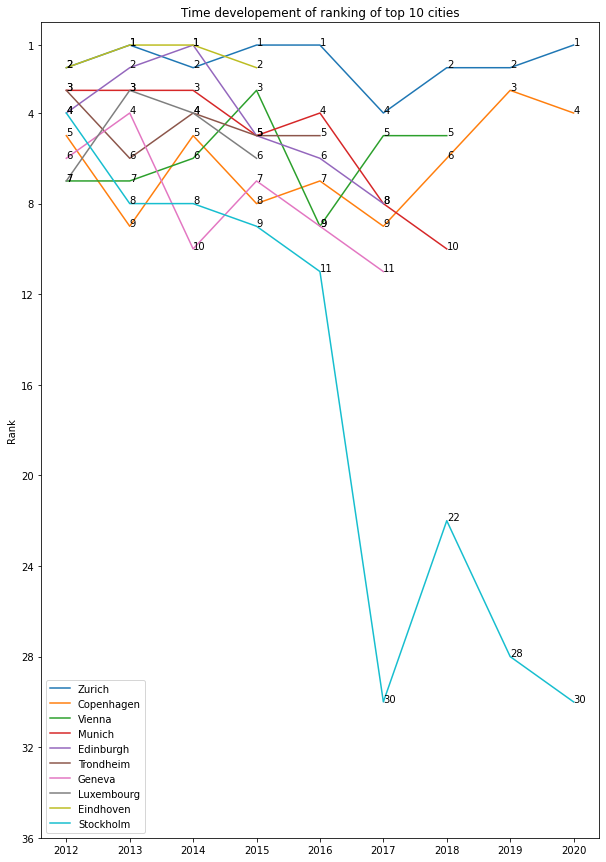

In [186]:
top_10=cities.head(10)
print(top_10)
time_dependency_top_10={}
for city in top_10["City"]:
    time_dependency_top_10[city]=[]
    for year in range(2012,2021):
        d=data[year]
        time_dependency_top_10[city].extend(d[d["City"]==city]["Rank"].to_list())
plt.figure(figsize=(10,15))
for time in time_dependency_top_10.keys():
    p=time_dependency_top_10[time]
    plt.plot(time_dependency_top_10[time])
    for j,i in zip(time_dependency_top_10[time],range(0,9)):
            plt.text(i,j,str(j))
plt.ylim(35,0)
plt.xticks(np.arange(9),("2012","2013","2014","2015","2016","2017","2018","2019","2020"))
plt.yticks((1,4,8,12,16,20,24,28,32,36))
plt.ylabel("Rank")
plt.title("Time developement of ranking of top 10 cities")
plt.legend(top_10["City"])
plt.savefig("Top_10_rankings_ranks")
plt.show()

For further clarity the same time developement was done for the scores of the top 10 cities by ranking.

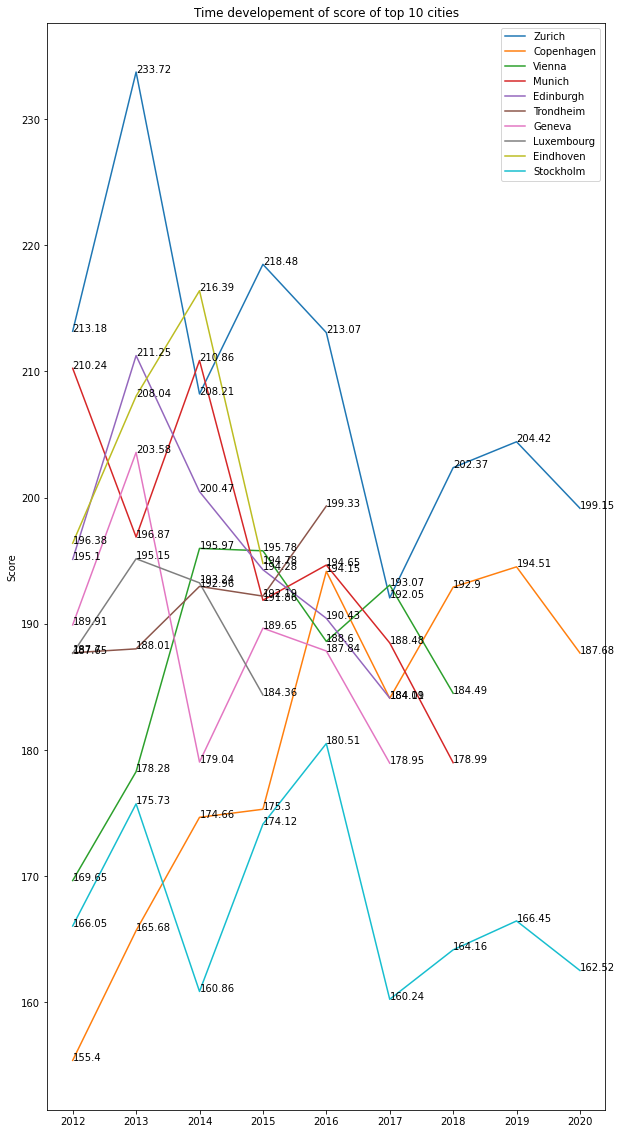

In [187]:
for city in top_10["City"]:
    time_dependency_top_10[city]=[]
    for year in range(2012,2021):
        d=data[year]
        time_dependency_top_10[city].extend(d[d["City"]==city]["Quality of Life Index"].to_list())
plt.figure(figsize=(10,20))
for time in time_dependency_top_10.keys():
    p=time_dependency_top_10[time]
    plt.plot(time_dependency_top_10[time])
    for j,i in zip(time_dependency_top_10[time],range(0,9)):
            plt.text(i,j,str(j))
plt.xticks(np.arange(9),("2012","2013","2014","2015","2016","2017","2018","2019","2020"))
plt.ylabel("Score")
plt.title("Time developement of score of top 10 cities")
plt.legend(top_10["City"])
plt.savefig("Top_10_scores")
plt.show()

### Scores Margin
As it was quite visible from the two graphs above that the rankings and scores do not move in aligned with eachother the next plot shows how the standard deviation changes over time.
From the plot below it can be derived that the difference between two scores which are attributed to two neighboring rankings is become smaller over time. This means that the margin between
scores is become thinner.

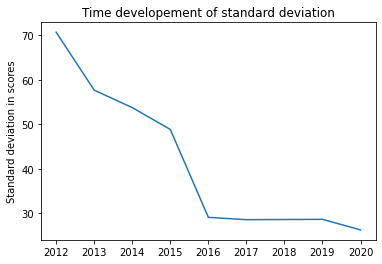

In [188]:
std=[]
for year in range(2012,2021):
    std.append(np.std(data[year]["Quality of Life Index"]))

plt.plot(std)
plt.xticks(np.arange(9),("2012","2013","2014","2015","2016","2017","2018","2019","2020"))
plt.title("Time developement of standard deviation")
plt.ylabel("Standard deviation in scores")
plt.savefig("Standard deviation")
plt.show()

At last we looked at the 10 cities which scored the highest accumulated scores over time. It can be seen that while the top candidates stayed the same the lower end was replaced by different cities.

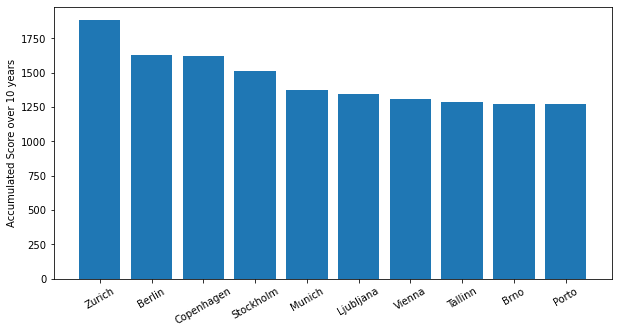

In [189]:
plt.figure(figsize=(10,5))
score_top_10=QOL_acc.sort_values(by="QOL_acc",ascending=False).head(10)
score_top_10.head()
plt.bar(x=score_top_10["City"],height=score_top_10["QOL_acc"])
plt.ylabel("Accumulated Score over 10 years")
plt.xticks(rotation=30)
plt.savefig("top10_scores")
plt.show()

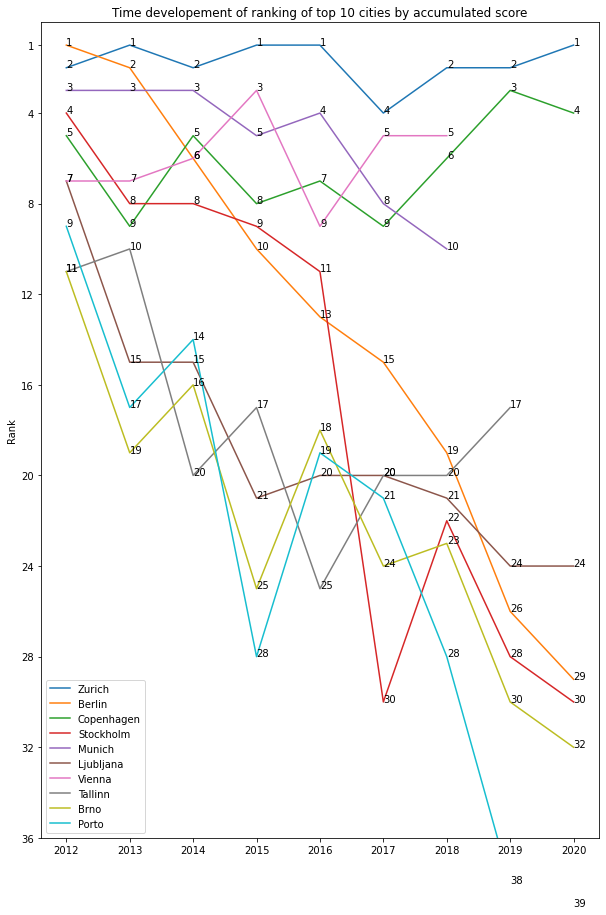

In [190]:
time_dependency_score_acc={}
for city in score_top_10["City"]:
    time_dependency_score_acc[city]=[]
    for year in range(2012,2021):
        d=data[year]
        time_dependency_score_acc[city].extend(d[d["City"]==city]["Rank"].to_list())
plt.figure(figsize=(10,15))
for time in time_dependency_score_acc.keys():
    p=time_dependency_score_acc[time]
    plt.plot(time_dependency_score_acc[time])
    for j,i in zip(time_dependency_score_acc[time],range(0,9)):
            plt.text(i,j,str(j))
plt.ylim(35,0)
plt.xticks(np.arange(9),("2012","2013","2014","2015","2016","2017","2018","2019","2020"))
plt.yticks((1,4,8,12,16,20,24,28,32,36))
plt.ylabel("Rank")
plt.title("Time developement of ranking of top 10 cities by accumulated score")
plt.legend(score_top_10["City"])
plt.savefig("top10_scores_scores")
plt.show()

# Regression Model

We evaluate the connection between the variables collected and the Quality of Life using a simple linear regression model profided by the sklean package. We refrain from suggesting any causality but note that the effect on the Quality of Life can be explained rather well using certain variables. 

In [191]:
import pandas as pd
import numpy as np
import os
import sklearn.model_selection as model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error

In [192]:
# define functions to calculate and print performance metrics
def print_metrics(groundtruth, predictions):
    print("Root Mean Squared Error: %.4f" % np.sqrt(mean_squared_error(groundtruth, predictions)))
    print("Mean Absolute Error: %.4f" % mean_absolute_error(groundtruth, predictions))
    print("Max Error: %.4f" % max_error(groundtruth, predictions))

In [193]:
all_inner = pd.read_csv('../data/Full_data_inner.csv')
print(all_inner.shape)
all_inner.head(2)

(648, 16)


,City,Year,Heatdays,Cooldays,Pollution,QOL,Unnamed: 0,Education Attainment ED 0-2,Education Attainment ED 3-4,Education Attainment ED 5-8,Deaths_in_road_accidents,Average Working Hours,Unemployment_Rate,E_Life_expextancy_at_birth,E_Med_Doctors_per_100000,Gender_Employment_Gap
0,Amsterdam,2019,2476.15,33.41,30.77,173.289993,567,17.9,33.7,48.5,32.0,30.8,3.2,82.2,487.53,7.9
1,Antwerp,2019,2372.84,37.23,60.27,157.899994,569,18.4,40.6,41.0,47.0,37.6,3.2,82.6,271.78,10.2


We split the data collected preciously into a target variables (Quality of Life) as well as into a train and a test set. The later split uses 75% for the train set and the remainder for the testing purpose. Also we have to omit the varibale Year as its numerical nature would distort the share of variance explained by other (reasonable) variables. The variable City has also to be omitted as the model estimation exploits the mechanical calculus of the ordinary least square approach which could not be performed with non numerical values. 

In [194]:
# split target variable from data
train_data = all_inner.drop(['City', 'Year', 'QOL'], axis=1)
train_values = all_inner.loc[:,'QOL']

# split data into training and test set
train_data, test_data, train_values, test_values = model_selection.train_test_split(
    train_data, train_values, random_state=20210123
)
train_data.head()

,Heatdays,Cooldays,Pollution,Unnamed: 0,Education Attainment ED 0-2,Education Attainment ED 3-4,Education Attainment ED 5-8,Deaths_in_road_accidents,Average Working Hours,Unemployment_Rate,E_Life_expextancy_at_birth,E_Med_Doctors_per_100000,Gender_Employment_Gap
162,2501.110000,2.400000,32.08,405,18.4,37.2,44.4,29.0,30.8,4.5,82.0,477.75,8.5
78,2435.905902,137.450984,14.73,626,21.4,33.5,45.2,0.0,39.2,3.5,83.2,391.22,5.6
419,2645.150000,142.410000,25.29,185,32.8,55.2,12.0,99.0,40.5,10.4,74.2,212.35,9.7
503,2965.550000,0.000000,32.86,107,20.9,32.7,46.4,36.0,35.5,13.6,81.3,303.95,10.6
537,2636.540000,95.890000,47.99,151,22.6,63.2,14.2,99.0,40.3,5.2,74.8,345.97,14.6


The function for the ordinary least squares regression is taken from the sklean package. So are all further methods like the predict and fit functions.

In [195]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_data, train_values)

# Make predictions using the testing set
pred = regr.predict(test_data)

# Print metrics
print_metrics(test_values, pred)

Root Mean Squared Error: 30.3892
Mean Absolute Error: 22.2836
Max Error: 111.9582


Overall the root mean squared error and the mean absolute error are not too far off making up 20.58% and 15.37% of the mean quality of life which equals 149.44. This suggests that the set of variables collected is rather useful to explain the Quality of life of the observed cities and years.
Some outliers of course exist. The most drastic one being Riga in 2013 where the predicted Quality of life has been grossly overestimated. 

In [196]:
regr.coef_

array([-1.32120327e-03,  1.72633805e-02, -1.08107247e+00,  2.23847608e-02,
        6.27856596e+00,  5.89015948e+00,  5.89213872e+00, -7.67066447e-02,
       -2.98977671e+00, -1.97256433e+00,  1.53135736e+00, -7.12027593e-03,
        2.60571638e-01])

In [197]:
coefficents = pd.DataFrame(regr.coef_)
coefficents = coefficents.T
coefficents.columns = list(train_data.columns) 
coefficents.index = ['all Years']
coefficents

,Heatdays,Cooldays,Pollution,Unnamed: 0,Education Attainment ED 0-2,Education Attainment ED 3-4,Education Attainment ED 5-8,Deaths_in_road_accidents,Average Working Hours,Unemployment_Rate,E_Life_expextancy_at_birth,E_Med_Doctors_per_100000,Gender_Employment_Gap
all Years,-0.001321,0.017263,-1.081072,0.022385,6.278566,5.890159,5.892139,-0.076707,-2.989777,-1.972564,1.531357,-0.00712,0.260572


The above data frame shows the fitted coefficients for the ordinary least squares linear regression model applied. Even though we would not expect to have overfitted the training data (486 cases and 12 variables) we see unexpected results which might stem from too little variance within the data or too much correlation between variables and target. While the positive coefficient of all education variables are easy to explain, we find it rather surpising that cool weather positively correlates with quality of life while hot weather correlates negatively. On the other hand, "metrics of unfortunate events" like death in road accidents, unemployment rate, and average working hours show negative effect on quality of life suggesting that fewer road accidents and working hours as well as a lower unemployment rate might increase the quality of life. A possibility for further research presents the partialy contradictory effects of working hours, unemployment rate and gender employment gap of which the later conflicts with our expectation that quality of life profits from decreased inequality. The reason for this conflict might be an overfitting of the variance through these tightly linked variables. The same might be true for the effect of like expectancy an the relative number of doctors per 100,000 inhabitants. Naturally, we would have expected the quality of life to increase with the number of doctors. However, the reason for the suggests negative correlation between doctors and quality of life might be the over fitting of variance in using life expectancy and number of doctors in the same model. 